이번 실습에서는 HI 21cm 전파 데이터를 분석해 보겠습니다.

## 1. HI data cube 살펴보기

![structure_hicube.png](structure_hicube.png)

그림1: HI cube 의 구조

HI cube 는 위처럼 RA (x) 방향, Dec (y) 방향, Vel (z) 방향의 차원으로 이루어진 3차원 구조를 가지고 있습니다.

주로 fits 확장자 형태로 저장되며, fits viewer를 통해 내용을 살펴볼 수 있습니다.

fits viewer는 여러가지가 있지만, 이 실습에서는 Windows에서도 사용이 가능한 QFitsView를 사용하겠습니다.

### 1.1 HI data cube 다운받기

https://www2.mpia-hd.mpg.de/THINGS/Data.html

에서 은하를 하나 골라서 na data cube를 다운받습니다.

이 예시에서는 DDO 154의 na 데이터 큐브를 사용하겠습니다.

In [ ]:
# 모듈이 깔려있지 않다면 설치
# !pip install astropy
# !pip install numpy
# !pip install spectral_cube
# !pip install tqdm

In [1]:
# astropy fits 모듈 불러오기
from astropy.io import fits

# 데이터 읽기
path_cube = 'HO_I_NA_CUBE_THINGS.FITS' #상대경로 혹은 절대경로로 지정
hdu = fits.open(path_cube)[0]  # header data unit을 배열과 비슷한 형태로 가져옴. path_cube[0]은 HDU를 보여줌.
hedr_cube = hdu.header
data_cube = hdu.data

데이터 큐브의 헤더를 출력해 봅시다.

In [2]:
keys = list(hedr_cube.keys())[:47]

for key in keys:
    print(key, hedr_cube[key])

SIMPLE True
BITPIX -32
NAXIS 4
NAXIS1 1024
NAXIS2 1024
NAXIS3 36
NAXIS4 1
EXTEND True
BLOCKED True
OBJECT UGC 5139
TELESCOP VLA
INSTRUME VLA
OBSERVER AP196
DATE-OBS 1991-03-07
DATE-MAP 2005-04-14
BSCALE 1.0
BZERO 0.0
BUNIT JY/BEAM
EPOCH 2000.0
VELREF 2
ALTRVAL 1418671491.64
ALTRPIX -63.0
OBSRA 145.117362322
OBSDEC 71.186322226
RESTFREQ 1420405752.0
DATAMAX 0.0241023358
DATAMIN -0.007032727823
CTYPE1 RA---SIN
CRVAL1 145.117362322
CDELT1 -0.0004166666768
CRPIX1 512.0
CROTA1 0.0
CTYPE2 DEC--SIN
CRVAL2 71.186322226
CDELT2 0.0004166666768
CRPIX2 513.0
CROTA2 -0.5035250783
CTYPE3 FELO-HEL
CRVAL3 190000.0
CDELT3 -2579.815918
CRPIX3 0.0
CROTA3 0.0
CTYPE4 STOKES
CRVAL4 1.0
CDELT4 1.0
CRPIX4 1.0
CROTA4 0.0


헤더의 각 요소에 접근하려면 아래처럼 하면 됩니다.

In [3]:
print(hedr_cube['NAXIS1'])

1024


$x$(RA)축의 픽셀 수가 $1024$개인 것을 알 수 있습니다.

#### Ex 1. $z$ 축의 픽셀 수 출력해보기

In [4]:
print(hedr_cube['NAXIS3'])

36


데이터 큐브의 모양(shape)을 출력해보면,

In [5]:
print(data_cube.shape)

(1, 36, 1024, 1024)


위처럼 4(STOKES), 3($z$), 2($y$), 1($x$) 순으로 차원이 배열된 것을 확인할 수 있습니다. (1, 2, 3, 4 순이 아님에 주의!)

우선 우리는 STOKES차원이 필요없기 때문에 아래와 같이 데이터를 수정해서 사용합시다.

(regrid cube의 경우엔 할 필요 없음)

In [6]:
data_cube = hdu.data
data_cube = data_cube[0,:,:,:] # 데이터 순서는 거꾸로 되어 있음에 주의
print(data_cube.shape)

(36, 1024, 1024)


#### Ex 2. cube 데이터 액세스

$(x,y,z)=(500,500,30)$ 위치의 값을 출력해 보세요. 

In [10]:
data_cube[31,501,501]
print(data_cube[0])

[[ 1.5829657e-03  1.4286257e-03  2.0642790e-03 ... -1.7218955e-04
   8.2963845e-04  1.8872457e-03]
 [ 1.3843802e-03  5.6348264e-04  1.3109383e-03 ...  3.7867943e-04
   1.2433095e-03  2.1617534e-03]
 [ 1.0965924e-03 -2.1820272e-04  2.9137838e-04 ...  1.6557354e-04
   9.9781447e-04  1.8939184e-03]
 ...
 [ 5.5444438e-04  1.0815582e-03  6.0595945e-04 ...  1.2557076e-04
   2.8205148e-05 -2.2903077e-06]
 [ 9.8065543e-04  1.4440423e-03  1.0892960e-03 ... -2.3788636e-04
  -2.0557395e-04  3.2159797e-04]
 [ 1.5033487e-03  1.7874766e-03  1.8355453e-03 ... -5.7170959e-04
   5.7448538e-05  1.0883432e-03]]


### 1.2 프로파일 그려보기

큐브 정 가운데 위치 쯤의 프로파일을 그려봅시다.

In [8]:
# 모듈 불러오기
from spectral_cube import SpectralCube

# 속도축 부르기
spectral_axis = SpectralCube.read(path_cube).spectral_axis.value / 1000 # 길이가 36개인 배열이다. 36개는 등차로 되어 있는 속도 데이터를 주고 있다. 이 속도 데이터는 모든 픽셀에서 동일하게 사용한다.
                                                                    # ^ m/s -> km/s
print(spectral_axis) # 속도축은 실제 관측자가 임시로 36개를 등차로 나눈 값들이다. 이 값들은 관측자들이 임의로 정한 값이기에 건드려선 안된다. 1024x1024개가 36개의 스펙트럼을 갖는다고 생각하면 된다.

[187.42020627 184.84045691 182.26075192 179.68109129 177.10147504
 174.52190315 171.94237563 169.36289247 166.78345368 164.20405924
 161.62470917 159.04540346 156.4661421  153.88692511 151.30775247
 148.72862418 146.14954025 143.57050067 140.99150544 138.41255457
 135.83364804 133.25478586 130.67596803 128.09719454 125.5184654
 122.9397806  120.36114015 117.78254404 115.20399226 112.62548483
 110.04702173 107.46860297 104.89022855 102.31189846  99.7336127
  97.15537128]


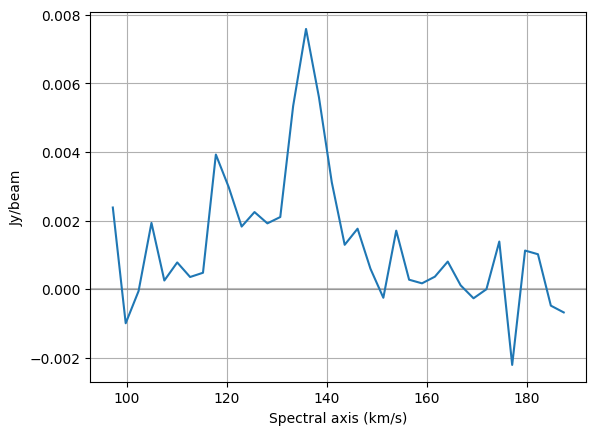

In [11]:
import matplotlib.pyplot as plt
import sys

x = int(hedr_cube['NAXIS1']/2)
y = int(hedr_cube['NAXIS2']/2)

"""
x = 300
y = 300
"""
fig, ax = plt.subplots()
ax.grid()
ax.axhline(0, color='gray', alpha=0.5)
ax.plot(spectral_axis, data_cube[:,y,x]) #y축은 flux density, x축은 속도
ax.set_xlabel('Spectral axis (km/s)')
ax.set_ylabel('Jy/beam')
plt.show()

### 1.3 QFitsView 로 cube 살펴보기

## 2. moment 분석

3차원 데이터는 2차원의 모니터에서 분석하기에 직관적이지 않아서 해석이 어려울 때가 있습니다.

이를 위해서 종종 moment 방법(method of moments)을 통해서 3차원의 데이터큐브를 2차원으로 만들어서 분석하기도 합니다.

### 2.1 0차 모멘트 (zeroth moment)

zeroth moment (moment 0)는 시선방향의 전체 플럭스 밀도(flux density)를 더한 값입니다. 

이를 통해서 **시선방향의 가스의 양**을 파악할 수 있습니다. 

한 픽셀$(x,y)$에 대해 아래와 같이 나타낼 수 있습니다.


$$ \begin{equation}
M_0(x,y) = \Delta v \sum_z S(x,y,z) \ ,
\end{equation}$$

여기서 $x$, $y$, $z$는 각 축에서의 위치값, $\Delta v$는 $z$방향 채널의 속도폭, $S$는 플럭스 밀도입니다. 

플럭스 밀도 $S$의 단위는 $\mathrm{Jy \, beam^{-1}}$, 속도의 단위는 보통 $\mathrm{km \, s^{-1}}$ 을 사용하기 때문에 moment0 값의 단위는 $\mathrm{Jy \, beam^{-1} \, km \, s^{-1}}$가 됩니다. 

$(1 \ \mathrm{Jy} = 10^{-26} \ \mathrm{W \, m^{-2} \, Hz^{-1}})$

moment 0 을 구하기 위해서 위에서 사용했던 데이터 큐브를 이용해봅시다.

In [12]:
import numpy as np

# mom0을 구한 결과를 저장하기 위한 빈 배열 선언
data_mom0 = np.zeros_like(data_cube[0,:,:])
print(data_mom0)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
#delta_v 값을 구하기 위해 헤더의 CDELT3값 이용하기
print(hedr_cube['CDELT3'])

-2579.815918


이 값은 m/s 단위의 값이기 때문에 1000으로 나눠서 km/s로 바꾸고 부호를 제거해 주겠습니다.

In [13]:
delta_v = np.abs(hedr_cube['CDELT3']/1000.)
print(delta_v)

2.579815918


이제 아래 셀을 이용해서 각 $x$, $y$ 위치에서의 mom0 값을 계산해 봅시다.

In [14]:
def calc_mom0(data, delta_v):
    return delta_v * np.sum(data)

for y in range(hedr_cube['NAXIS2']):
    for x in range(hedr_cube['NAXIS1']):
        data_mom0[y,x] = calc_mom0(data_cube[:,y,x], delta_v)

이제 이 2D 데이터를 ``pyplot.imshow`` 모듈을 이용해서 시각화 해봅시다.

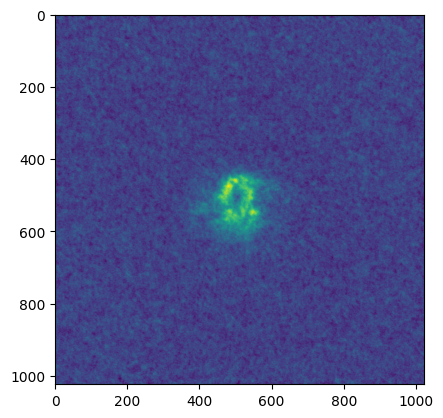

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(data_mom0, cmap='viridis')
plt.show()

이처럼 기본 설정에서는 y축이 반전되어 있기 때문에 y축을 다시 반전시키고, 컬러바 등등을 추가해서 다시 그려봅시다.

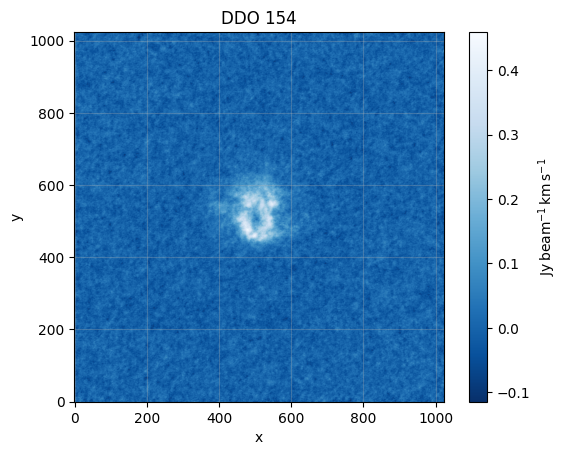

In [16]:
fig, ax = plt.subplots()
ax.grid(alpha=0.3)
map = ax.imshow(data_mom0, cmap='Blues_r')
ax.invert_yaxis()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('DDO 154')
fig.colorbar(map, label=r'$\mathrm{Jy \, beam^{-1} \, km \, s^{-1}}$')

이처럼 mom0 맵을 통해 시선방향의 가스맵 분포를 확인할 수 있습니다.

### 2.2 1차 모멘트 (1st moment)

다음으로, 1차 모멘트(1st moment, mom1)는 플럭스밀도로 가중치를 준 시선방향 속도입니다.

$$\begin{equation}
M_1(x,y) = \frac{\sum_z v(z) S(x,y,z)}{\sum_z S(x,y,z)}
\end{equation}$$

$z$축에 대한 일종의 평균을 내는 것이기 때문에 mom1 이미지는 시선방향의 HI 방출선의 중심속도를 보여준다고 할 수 있습니다.

#### Ex 3. 1차 모멘트 맵을 만들고 그려봅시다.

여기엔 z방향의 속도값이 필요합니다. 앞서 구한 ``spectral_axis`` 를 사용하면 됩니다.

In [17]:
"""
data_mom1 = np.zeros_like(data_mom0)
spectral_axis = SpectralCube.read(path_cube).spectral_axis.value / 1000

def calc_mom1(data, spectral_axis):
    return 
"""
data_mom1 = np.zeros_like(data_mom0)

#method 1
def calc_mom1(data, spectral_axis):
    return np.sum(spectral_axis * data) / np.sum(data)

for y in range(hedr_cube['NAXIS2']):
    for x in range(hedr_cube['NAXIS1']):
        data_mom1[y,x] = calc_mom1(data_cube[:,y,x], spectral_axis)


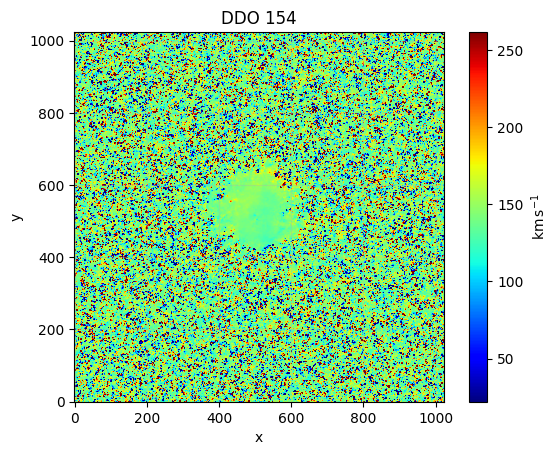

In [18]:
# mom1맵 그리기
fig, ax = plt.subplots()
ax.grid(alpha=0.3)
map = ax.imshow(data_mom1, cmap='jet', clim=np.nanpercentile(data_mom1, (5,95)))
ax.invert_yaxis()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('DDO 154')
fig.colorbar(map, label=r'$\mathrm{km \, s^{-1}}$')

### 2.3. 2차 모멘트 (2nd moment)

마지막으로, 2차 모멘트(mom2)는 mom1값을 기준으로 한 속도 분산으로, 시선방향 가스 프로파일의 폭에 대한 정보를 줍니다.

$$ \begin{equation}
M_2(x,y) = \sqrt{\frac{\sum_z[v(z)-M_1(x,y)]^2 S(x,y,z)}{\sum_z S(x,y,z)}}
\end{equation} $$

In [19]:
def calc_mom2(data, spectral_axis, mom1):
    return np.sqrt( np.sum((spectral_axis - mom1)**2 * data)  / np.sum(data))

mom0, 1, 2를 이전에 그린 프로파일에 표시해보면 아래와 비슷합니다.

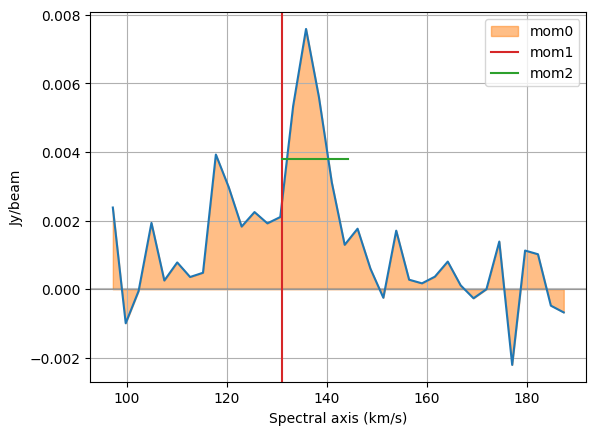

In [20]:
import matplotlib.pyplot as plt

x = int(hedr_cube['NAXIS1']/2)
y = int(hedr_cube['NAXIS2']/2)

data = data_cube[:,y,x]
mom1 = calc_mom1(data, spectral_axis)
mom2 = calc_mom2(data, spectral_axis, mom1)

fig, ax = plt.subplots()
ax.grid()
ax.axhline(0, color='gray', alpha=0.5)
ax.plot(spectral_axis, data)
ax.set_xlabel('Spectral axis (km/s)')
ax.set_ylabel('Jy/beam')

ax.fill_between(spectral_axis, data, 0, color='tab:orange', alpha=0.5, label='mom0')
ax.axvline(mom1, color='tab:red', label='mom1')

x_at_peak = spectral_axis[np.argmax(data)]
ax.plot([mom1, mom1+mom2], [np.max(data)/2, np.max(data)/2], color='tab:green', label='mom2')

ax.legend()



plt.show()

### 2.4 mom0,mom1,mom2

아래 코드를 사용해서 위 모멘트 맵들을 한번에 살펴볼 수 있습니다.

mom1: 100%|██████████| 1024/1024 [00:06<00:00, 169.98it/s]
C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_17976\765356094.py:56: RuntimeWarning: invalid value encountered in divide
  mom1 = np.where(mom0>0.0, mom1/mom0, mom1)
mom2: 100%|██████████| 1024/1024 [00:07<00:00, 130.79it/s]
C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_17976\765356094.py:62: RuntimeWarning: invalid value encountered in divide
  mom2 = np.where(mom0>0.0, np.sqrt(mom2/mom0), mom2)


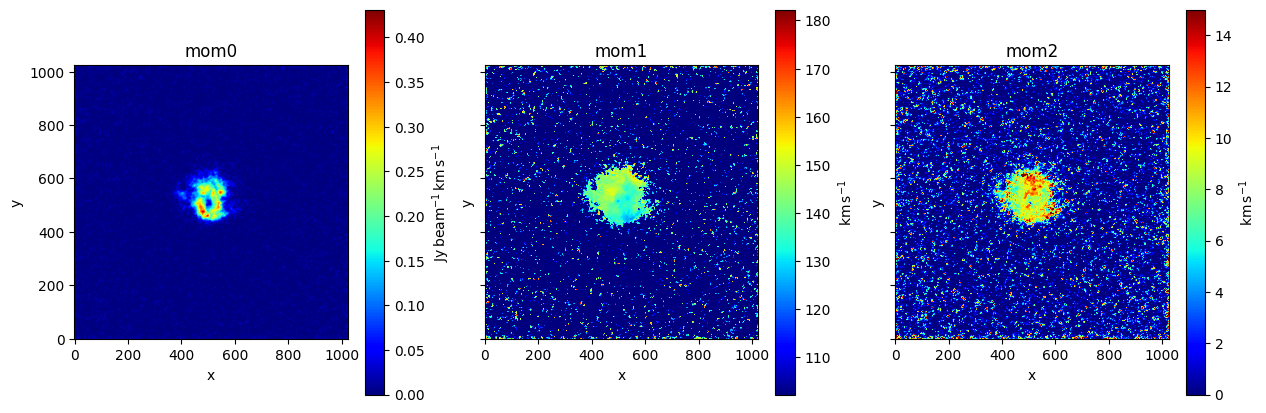

In [21]:
from astropy import wcs
from tqdm import tqdm
from typing import Optional

def genmomaps(path_cube: str,
              path_mask: Optional[str]='', 
                ):
    """
    Generating moment and peak flux density maps from a data cube
    path_cube (string) : Input data cube
    path_mask (string): Mask data cube 
    """    
    # Check if mask exists and read in mask
    if path_mask != '':
        hdulist = fits.open(path_mask)
        data_mask = hdulist[0].data      
    
    # Open example FITS cube and extract WCS header keywords and data
    hdulist = fits.open(path_cube)
    wcshead = wcs.WCS(hdulist[0].header, naxis=3)
    data_cube = hdulist[0].data
    if(len(data_cube.shape)>3):
        data_cube = data_cube[0,:]
    
    # Read cube dimensions and create arrays for maps
    nz, ny, nx = data_cube.shape
    
    if path_mask == '':
        data_mask = np.ones((nz,ny,nx), dtype=float)
    
    threshold = np.nanstd(data_cube)
    data_cube[data_cube<2*threshold] = 0.

    mom0 = np.zeros((ny,nx))
    mom1 = np.zeros((ny,nx))
    mom2 = np.zeros((ny,nx))

    # Convert channel numbers to velocity using WCS
    velo = [0 for z in range(nz)]
    for z in range(nz):
        equ_coords = wcshead.wcs_pix2world(0, 0, z, 0)
        velo[z] = equ_coords[2] / 1000.0
    dv = abs(velo[1] - velo[0])

    data_masked = data_cube*data_mask #*(data_cube>threshold)

    # Create moment-0 and peak flux density maps
    for x in tqdm(range(nx), desc='mom0'):
        for y in range(ny):
            mom0[y,x] = np.sum(data_masked[:,y,x])
        
    # Create moment-1 map
    for x in tqdm(range(nx), desc='mom1'):
        for y in range(ny):
            mom1[y,x] = np.sum(velo * data_masked[:,y,x])
    mom1 = np.where(mom0>0.0, mom1/mom0, mom1)

    # Create moment-2 map
    for x in tqdm(range(nx), desc='mom2'):
        for y in range(ny):
            mom2[y,x] = np.sum( (velo - mom1[y,x])**2 * data_masked[:,y,x] )
    mom2 = np.where(mom0>0.0, np.sqrt(mom2/mom0), mom2)        
    
    mom0 *= dv

    fig, axs = plt.subplots(figsize=(15,5), ncols=3, sharex=True, sharey=True)
    
    img1 = axs[0].imshow(mom0, cmap='jet')
    img2 = axs[1].imshow(mom1, cmap='jet', clim=np.nanpercentile(np.where(mom1==0, np.nan, mom1), (5,95)))
    # img3 = axs[3].imshow(mom2, cmap='jet', clim=np.nanpercentile(np.where(mom2==0, np.nan, mom2), (0,99)))
    img3 = axs[2].imshow(mom2, cmap='jet', clim=(0,15))
    
    plt.colorbar(img1, label=r'$\mathrm{Jy \, beam^{-1} \, km \, s^{-1}}$')
    plt.colorbar(img2, label=r'$\mathrm{km \, s^{-1}}$')
    plt.colorbar(img3, label=r'$\mathrm{km \, s^{-1}}$')
    
    axs[0].set_title('mom0')
    axs[1].set_title('mom1')
    axs[2].set_title('mom2')
    
    axs[0].invert_yaxis()
    
    for ax in axs:
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    
    plt.show()
    
    return mom0, mom1, mom2
    
data_mom0, data_mom1, data_mom2 = genmomaps(path_cube=path_cube)

## 3. HI 질량 $M_\mathrm{HI}$ 구하기

앞서 구한 mom0 데이터로 은하의 HI 질량을 추정해 봅시다.

HI 질량은 다음 식을 이용해서 구할 수 있습니다.

$$\begin{equation}
\frac{M_\mathrm{HI}}{\mathrm{M_\odot}} = 0.236 \times \frac{S_\mathrm{int}}{\mathrm{Jy \, km \, s^{-1}}} \times \left( \frac{d}{\mathrm{kpc}} \right)^2
\end{equation}$$

여기서 $S_\mathrm{int}$ 는 integrated flux, $d$는 은하까지의 거리입니다.

$S_\mathrm{int}$ 는 속도방향으로 모두 합친 flux 인데, 단위를 보면, 우리가 구했던 mom0 값에 beam 값을 곱해준 양이 됩니다.

변환하기 위해 mom0 을 beam solid angle $\Omega_\mathrm{PSF}$ 으로 나눠줍니다.

$$\begin{equation}
S_\mathrm{int} = \frac{\mathrm{mom0}}{\Omega_\mathrm{PSF}}
\end{equation}$$

$$\begin{equation}
\Omega_\mathrm{PSF} = \frac{\pi B_\mathrm{maj} B_\mathrm{min}}{4 \ln(2)} \approx 1.13399 \, B_\mathrm{maj} \, B_\mathrm{min}
\end{equation}$$

여기에서 $B_\mathrm{min}$ 와 $B_\mathrm{min}$은 각각 beam의 major axis, minor axis 방향 크기로, pixel 단위를 사용해야 합니다.

각 데이터의 arcsecond 단위 beam size는 아래 사진이나 [Walter et al. (2008)](https://ui.adsabs.harvard.edu/abs/2008AJ....136.2563W/abstract) 의 Table 3 에서 찾아볼 수 있습니다.

![table3_walter08_beams.png](table3_walter08_beams.png)

그림2: THINGS 데이터별 beam size (Table 3., Walter et al. 2008)

이 예시에서 사용하고 있는 데이터는 DDO 154의 NA weighting cube 이기 때문에, 

$B_\mathrm{maj}=14.09''$, $B_\mathrm{min}=12.62''$ 가 되고, 

이를 pixel size $1.5 '' \, \mathrm{pix}^{-1}$ 로 나눠주면 아래와 같습니다.

In [22]:
Bmaj = 14.09 / 1.5
Bmin = 12.62 / 1.5
# regrid cube를 사용할 경우엔 pixel_size = Bmaj로 사용

print('Beam size in pixel unit:')
print('     Bmaj = {:.2f} pix'.format(Bmaj))
print('     Bmin = {:.2f} pix'.format(Bmin))

Beam size in pixel unit:
     Bmaj = 9.39 pix
     Bmin = 8.41 pix


따라서 beam solid angle $\Omega_\mathrm{PSF}$는,

In [23]:
Omega = 1.13399 * Bmaj * Bmin

print('Beam solid angle = {:.2f} pix^2 per beam'.format(Omega))

Beam solid angle = 89.62 pix^2 per beam


를 얻고, 이것이 우리가 mom0의 단위에서 봤던 beam 이 됩니다.

이제 $S_\mathrm{tot}$ 과, $S_\mathrm{int}$ 를 차례로 구해보면,

In [24]:
Stot = np.sum(data_mom0)
Sint =  Stot / Omega

print('Integrated flux density:')
print('     Sint = {:.2f} Jy km/s'.format(Sint))

Integrated flux density:
     Sint = 78.95 Jy km/s


을 얻습니다.

이제 $S_\mathrm{int}$ 를 질량으로 변환하기 위해서는 거리정보가 필요한데, 이는 같은 논문의 Table 1. 에 나와 있습니다.

![table1_walter08_distance.png](table1_walter08_distance.png)

그림3: THINGS 은하별 정보 (Table 1., Walter et al. 2008)

DDO 154 의 경우엔 우리로부터 $4.3 \ \mathrm{Mpc}$ 떨어져 있네요.

이를 이용해서 계산하면,

In [ ]:
M_HI = 

print('HI Mass:')
print('     M_HI = {:.2f} Msol'.format(M_HI))
print('          = {:.2f} x 10^8 Msol'.format(M_HI/1e8))

을 얻습니다.

얻은 $S_\mathrm{int}$ 와 $M_\mathrm{HI}$ 을 논문의 값과 비교해 봅시다.


![table5_walter08_masses.png](table5_walter08_masses.png)

그림4: THINGS 은하별 HI 물리량 (Table 5., Walter et al. 2008)